In [10]:
%matplotlib inline  
import sys
from datasets import *
from base import *
import  models
import logging
import utils
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D



logging.getLogger("tensorflow").setLevel(logging.ERROR)

hparams = Hyperparameters()
hparams.num_epochs = 100
hparams.batch_size = 60
hparams.initial_learning_rate = 1e-3
hparams.cut_layer = "pool3"
hparams.activation = "relu"
# hparams.batch_norm = "batc_norm"
hparams.hidden_layers = [2048]
hparams.fine_tunning = True
hparams.bottleneck = True
hparams.normalization = "batch_norm"
hparams.keep = 0.3
hparams.regularizer_type = 2
hparams.regularizer_scale = 0.005

# data = Cifar10(hparams, tfrecord = False)
data = Star(hparams, is_3_images = True, tfrecord = True)
os.system("rm -rf {}/{}/*".format(hparams.checkpoints_path, data.get_name()))


model1 = models.Vgg16(data, "pool3")
model2 = models.Vgg16(data, "pool3")
model3 = models.Vgg16(data, "pool3")
ensamble = models.Ensemble(data, True)
ensamble.add_models([model1,model2,model3])
# ensamble = models.Autoencoder(hparams,data)
# ensamble.build()
# ensamble.summary()

ensamble.train()
# images = ensamble.info_visualization(name_layer = "logits")
# ensamble.activation_maps()
# utils.plot_images(images)


# predictions = ensamble.test_prediction()
# utils.generate_confusion_matrix(predictions, hparams.class_names)

# import the inspect_checkpoint library
# from tensorflow.python.tools import inspect_checkpoint as chkp

# # print all tensors in checkpoint file
# chkp.print_tensors_in_checkpoint_file("./models/vgg_19.ckpt", '', True, False)
                               


File Star_train.tfrecords alread exists.
Buiding cnn from vgg_16 model.
Buiding cnn from vgg_16 model.
Buiding cnn from vgg_16 model.
Restoring the entire model.

*************************************************************
Epoch 1/100
--> Global step:   539 - Mean acc: 4.93% - Batch_loss: 7.1709 - (1.92, 115.24) (steps,images)/sec

*************************************************************
Epoch 2/100
--> Global step:   653 - Mean acc: 4.69% - Batch_loss: 6.0297 - (1.94, 116.17) (steps,images)/sec

*************************************************************
Epoch 3/100
--> Global step:   767 - Mean acc: 4.46% - Batch_loss: 5.1589 - (1.94, 116.50) (steps,images)/sec

*************************************************************
Epoch 4/100


KeyboardInterrupt: 

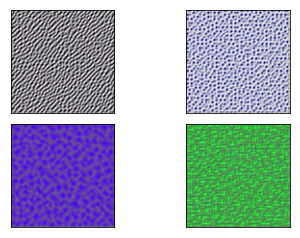

In [8]:
layer = ensamble.get_layers(2)
images = layer.visualize_features(list(range(64)))
utils.plot_images(images, (2,2))

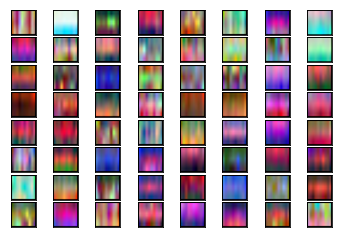

In [13]:
# ensamble.summary()
layer = ensamble.get_layers(6)
images = layer.visualize_weights()
utils.plot_images(images, (8,8), 50)


Loading test data...
Predicted_class:  11


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Predicted_class:  11
Predicted_class:  11
Predicted_class:  11
Predicted_class:  11
Predicted_class:  5
Predicted_class:  11
Predicted_class:  11
Predicted_class:  11
Predicted_class:  11
Predicted_class:  11
Predicted_class:  11
Predicted_class:  5
Predicted_class:  11
Predicted_class:  11
Predicted_class:  5
Predicted_class:  11
Predicted_class:  11
Predicted_class:  11
Predicted_class:  5
conv3d


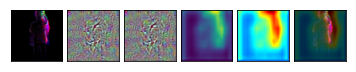

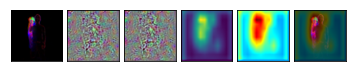

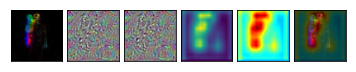

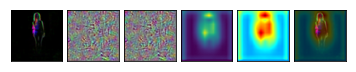

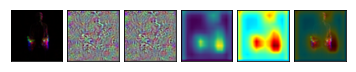

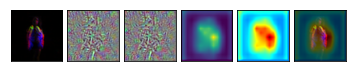

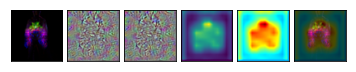

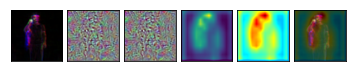

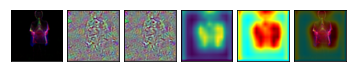

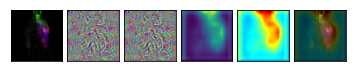

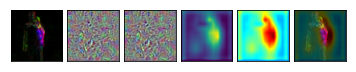

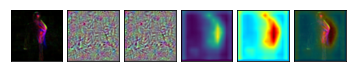

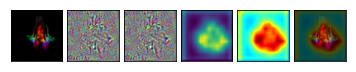

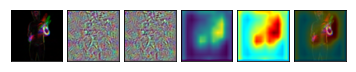

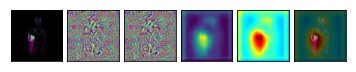

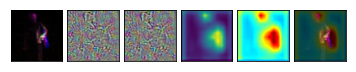

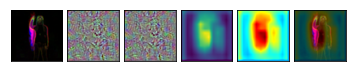

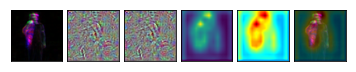

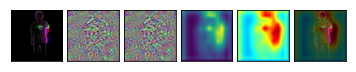

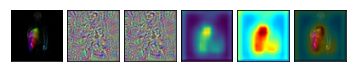

In [9]:
layer = ensamble.get_layers("conv3d")
images = data.get_sample()
labels = list(range(len(images)))
results = layer.activation_maps(images)
#        
print(layer)
# images = list(map( m.imread, glob.glob("./output/*.jpg")) )
for images in results:
    utils.plot_images(images, (1,6), 300)

/bin/sh: 1: wget: not found


In [ ]:
from  generate_star import *
import glob 
files = glob.glob("../../train/RGB/*.mp4")
data = []
labels = []
print("total files ", len(files))
for i,file in enumerate(files): 
    
    if i%500 == 0:
        print(i)
        
    frames = get_frames(file)
    if len(frames) > 5:
        star = normalize(get_star(frames) )
        star = get_star_1_RGB(frames)
        data.append(star)
        labels.append(get_label(file))
    # m.imsave(file.replace("mp4","png").replace("basta", "result"), star)
    

# images = []
# for star, frame in zip(video, frames):
#     image = np.ones((star.shape[0], 2*star.shape[1] + 10, star.shape[2]) )
#     print(frame.shape)
#     image[:,0:star.shape[1],:] = normalize(star, star1)
#     image[:,star.shape[1]+10:,:] = frame
#     images.append(image)

# star_clip = ImageSequenceClip(images, fps=3.0)
# star_clip.write_videofile("video_star.mp4") 

# videos = map(pims.Video, files)
# images = list(map(normalize, map(get_star,videos)))
print(len(labels), len(data))

star = {"data":data, "labels":labels}

with open("./data/star/star_1_rgb_validation.pkl", 'wb') as f:
    pickle.dump(star, f)



In [ ]:

x = np.random.random(100)
y = np.random.random(100)
c = np.random.choice(range(10), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(x, y, c=c, lw=0)

In [ ]:
a = list(range(5))
for i in a:
    if i == 0:
        del a[3]
    print i
    

In [ ]:
import numpy as np
import tensorflow as tf

def get_d_reg_kernel(kernel,w_inputs, w_output,  d, avgpool = False):
    if d == 0: d = 1
    
    default_value = 1.0 if not avgpool else 1./(kernel[0]**2)
    
    kernel =  [x*d-(d-1) for x in kernel]
    size = tuple( kernel + [w_inputs, w_output])
    
    if d > 1:
        init = np.zeros(size)
        ones = range(0,kernel[0],d)
        zeros = list(set(range(kernel[0])) - set(ones)) 
        init[ones,:,:,:] = default_value
        init[:,zeros,:,:] = 0

    else:
        init = np.ones(size) * default_value
    
    return init
    
def get_weights(w_inputs, w_output, kernel_size = [], d = 1, name = "conv/conv" ):
    xavier_init = tf.contrib.layers.xavier_initializer()
    
    init = get_d_reg_kernel(kernel_size,w_inputs, w_output, d)
    regularly_kernel = tf.constant(init, dtype = tf.float32, name="{}/{}_regularly".format(name, d))
    
        
    weights= tf.Variable(init, dtype = tf.float32, name="{}/weights".format(name))
    biases =  tf.Variable(xavier_init([w_output]), name="{}/biases".format(name))
    weights = tf.multiply(weights, regularly_kernel, name="{}/{}_regAplly".format(name,d))
    return weights, biases

def conv2d(x, out_channels, kernel,  name = "conv", d = 1, batch_norm = False, padding = "VALID"):
    depth = x.shape.as_list()[-1]  
    w, b = get_weights(depth, out_channels, kernel,d, name)
    x = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], name = name, data_format= "NHWC", padding = padding)

    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    if batch_norm:
        x = self.batch_norm(x, "{}/batch_norm" % name)

    return x 

def avgpool(x, k = 2, d = 1):
    if d < 2:
        return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, 1,1,1], padding='VALID' )
    x = tf.transpose(x, [0,3,1,2])
    x = tf.expand_dims(x, 4)
    init = get_d_reg_kernel([k,k], 1, 1,  d, avgpool = False)
    print(np.squeeze(init))
    filter = tf.constant(np.expand_dims(init, 0), dtype =tf.float32)
    pool = tf.nn.conv3d(x, filter, [1,1,1,1,1], data_format= "NDHWC", padding='VALID', name="pool")
    pool = tf.transpose(pool, [0,2,3,1,4])

    return tf.squeeze(pool, [4])

input = tf.constant(np.zeros((1,32,32,3)), dtype =tf.float32)
conv = conv2d(input, 64, [3,3], d = 2, name = "conv",  batch_norm = False, padding = "VALID")
pool = avgpool(conv, k = 3, d = 1)

print(conv)
print(pool)



In [ ]:
def fun0(a, b,c,d,e, f=78):
    print "a:",a
    print "b:",b
    print "c:",c
    print "d:",d
    print "e:",e
    print "f:",f
def fun(*args, **kwargs):
    print(args)
    print(kwargs)
    kwargs.update("f" : 32)
    fun0(*args,**kwargs)
fun(0, 1,e=3,d=4,c=5)